In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import pickle

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
from pathos.multiprocessing import Pool

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (16, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import sample_lsq_rates
from readdy_learn.example.regulation_network import sample_along_alpha

/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# try to generate reg network s.t. LSQ does not work properly

### Case 1
- LSQ fits well but doesnt necessarily recover the rates (varying $\alpha$)
- In the limit of low noise (and same initial conditions), the least squares solution (almost) recovers almost the right reactions (sparsity pattern). Vary hyperparameters (alpha, ~~lambda~~)
- use more basis functions

- timestep = $8\cdot 10^{-3}$: seems O.K.
- timestep = $6\cdot 10^{-3}$: lsq still works reasonably well
- timestep = $12 \cdot 10^{-3}$: lsq begins to get worse
    - this almost works, probably need a few more frames
- timestep = $24 \cdot 10^{-3}$: lsq picks up on processes that are definitely not there, ignores some of the correct ones
    - could not reproduce correct rates with lasso

In [4]:
def plot_l1_errors(regulation_network, results, cutoff=0.):
    l1_errors = []
    l1_std = []
    keys_sorted = np.array([k for k in sorted(results.keys())])
    for key in keys_sorted:
        # shape: (n_realizations, basis funs)
        rates = np.array(results[key])
        # build difference w correct rates
        ratesdiff = np.abs(np.array([r - regulation_network.desired_rates for r in rates]))
        l1norms = np.array([np.sum(x) for x in ratesdiff])
        l1_errors.append(np.mean(l1norms))
        l1_std.append(np.std(l1norms))
    l1_errors = np.array(l1_errors)
    l1_std = np.array(l1_std)
    plt.fill_between(keys_sorted, l1_errors-l1_std, l1_errors+l1_std,
                     color='b', alpha=.5)
    #plt.errorbar(keys, l2_mean, yerr=l2_std)
    plt.plot(keys_sorted, l1_errors)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('L1 error')
    ix = np.argmin(l1_errors)
    return l1_errors[ix], ix
def get_regulation_network(timestep):
    regulation_network = RegulationNetwork()
    regulation_network.timestep = timestep
    regulation_network.realisations = 1.
    regulation_network.noise_variance = 0.
    regulation_network.initial_states = [regulation_network.initial_states[1]]
    analysis = regulation_network.generate_analysis_object(fname_prefix='case_1', fname_postfix='0')
    for i in range(len(regulation_network.initial_states)):
        analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
        shape = analysis.trajs[i].counts.shape
        print("n_frames={}, n_species={}".format(*shape))
    regulation_network.compute_gradient_derivatives(analysis, persist=False)
    return regulation_network, analysis
def do(timestep, fname):
    regulation_network, analysis = get_regulation_network(timestep)
    alphas = np.logspace(-6, -4, num=200)
    result = sample_along_alpha(regulation_network, alphas=alphas)
    lsq_rates = analysis.least_squares(0, tol=1e-16, recompute=True, persist=False, verbose=False)
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    
    data = {
        'regularized_rates': result,
        'lsq_rates': lsq_rates
    }
    
    print("minimal l1 error: {} (ix {})".format(error, ix))
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
def show_results(fname):
    print("loading results from {}....".format(fname))
    regulation_network, analysis = get_regulation_network(1e-3)
    alphas = np.logspace(-6, -4, num=200)
    
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    
    result = data['regularized_rates']
    lsq_rates = data['lsq_rates']
    
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    print("minimal l1 error: {} (ix {})".format(error, ix))

# dt = 6e-3, 500 frames

n_frames=500, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

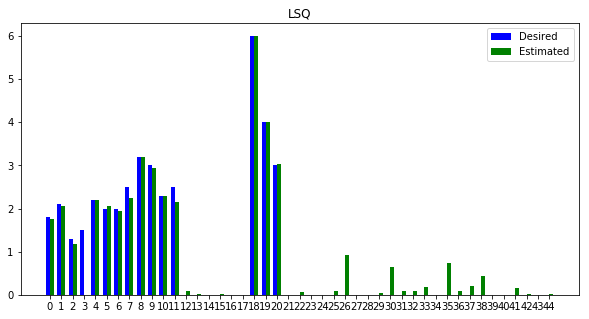

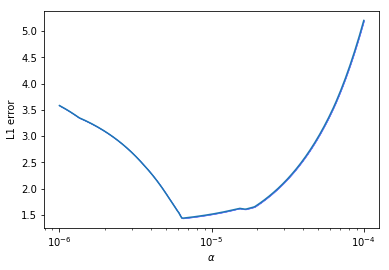

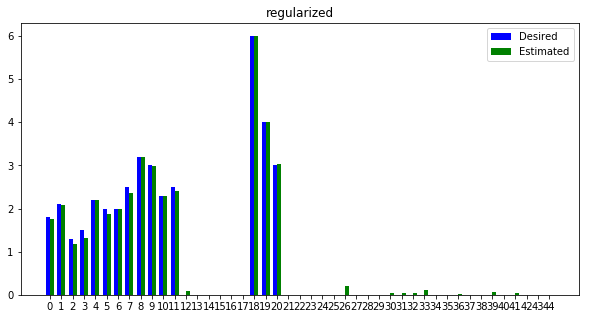

minimal l1 error: 1.4381371069862432 (ix 81)


In [10]:
do(6e-3, 'case_1_dt_6e-3.pickle')

# dt = 7e-3

n_frames=429, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

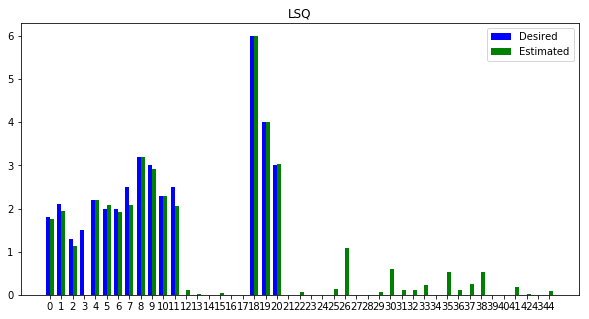

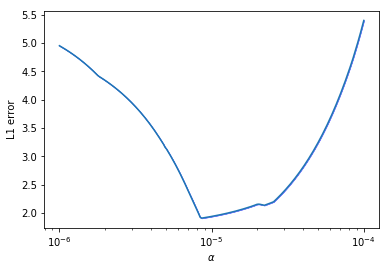

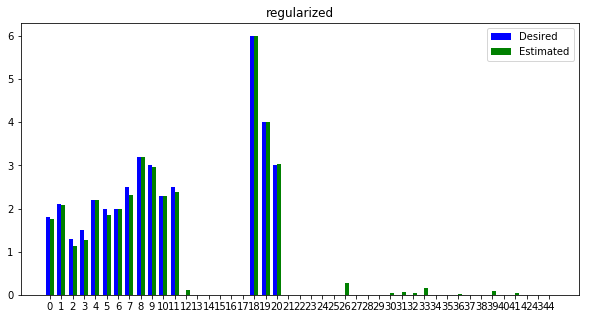

minimal l1 error: 1.910128688276026 (ix 93)


In [11]:
do(7e-3, 'case_1_dt_7e-3.pickle')

# dt = 9e-3, 334 frames

n_frames=334, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

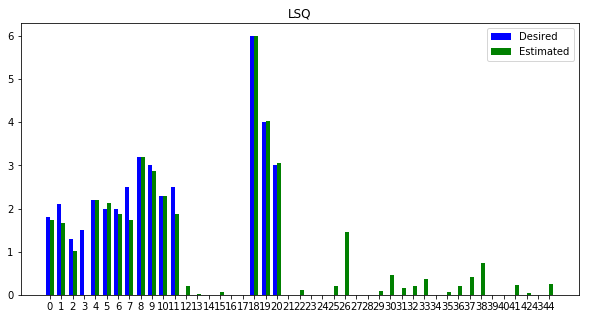

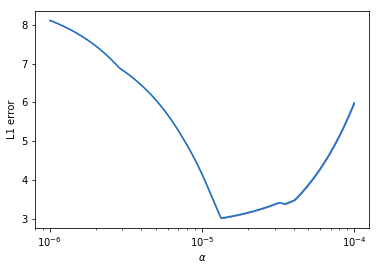

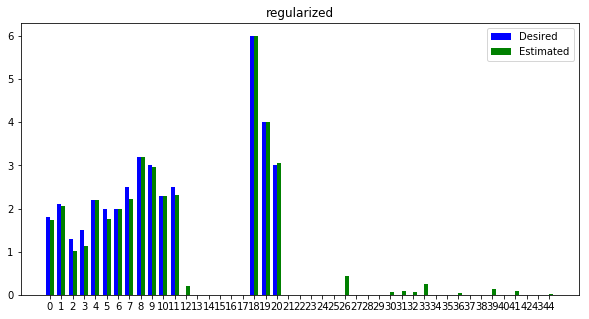

minimal l1 error: 3.0118495047914533 (ix 112)


In [5]:
do(9e-3, 'case_1_dt_9e-3.pickle')

# dt = 8e-3, 375 frames

n_frames=375, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

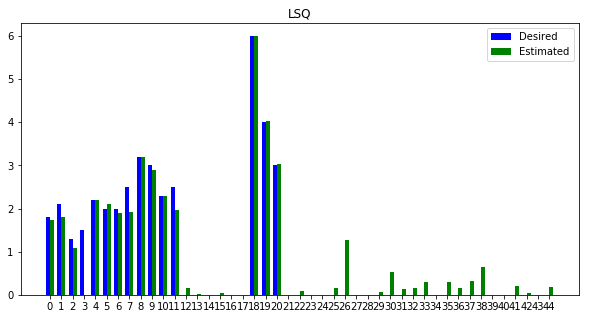

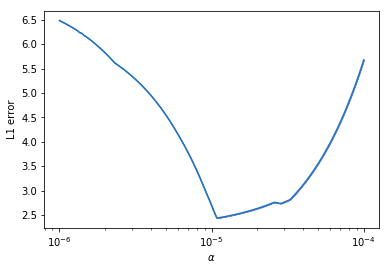

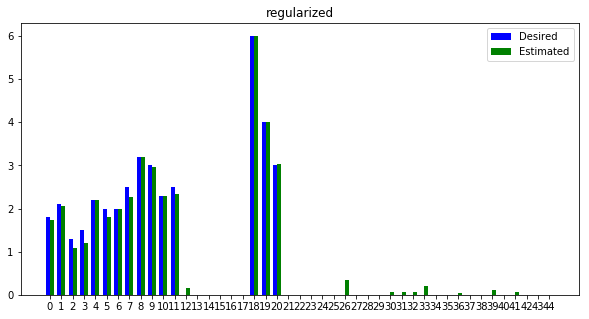

minimal l1 error: 2.4413878581035404 (ix 103)


In [6]:
do(8e-3, 'case_1_dt_8e-3.pickle')

# dt = 12e-3, 250 frames

n_frames=250, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

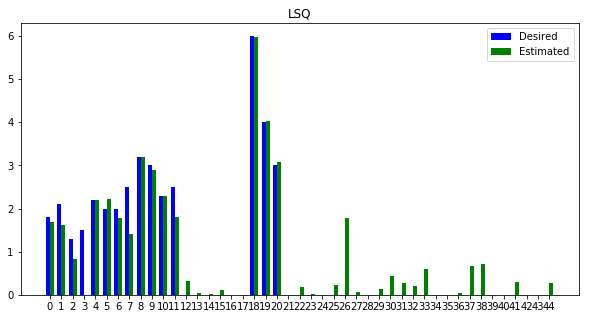

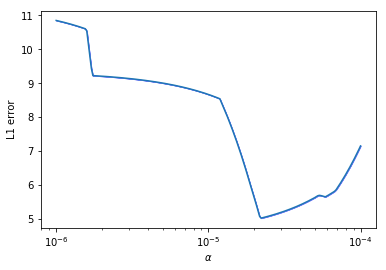

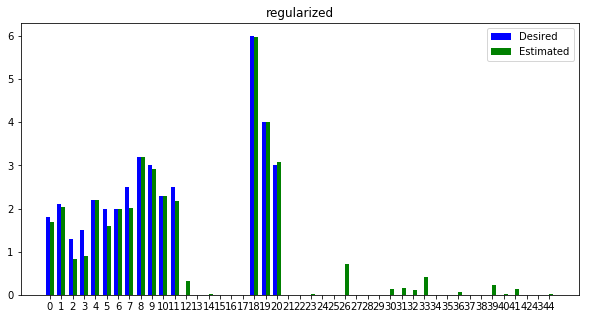

minimal l1 error: 5.031535876369794 (ix 134)


In [7]:
do(12e-3, 'case_1_dt_12e-3.pickle')

# dt = 16e-3, 188 frames

n_frames=188, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

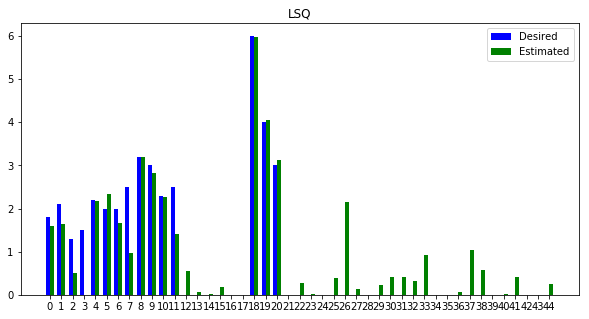

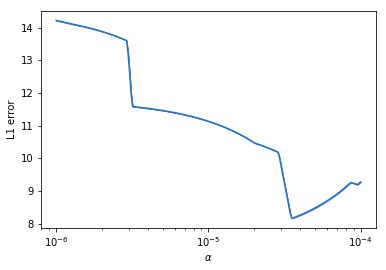

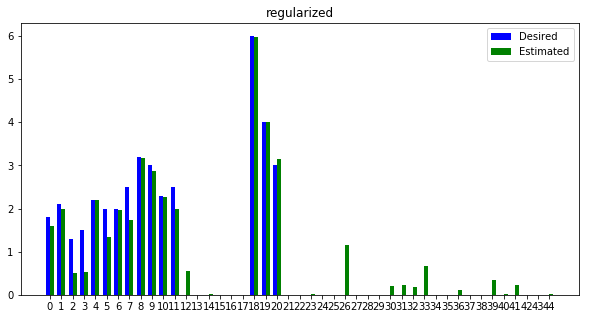

minimal l1 error: 8.165940035090607 (ix 154)


In [8]:
do(16e-3, 'case_1_dt_16e-3.pickle')

# dt = 24e-3, 125 frames

n_frames=125, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

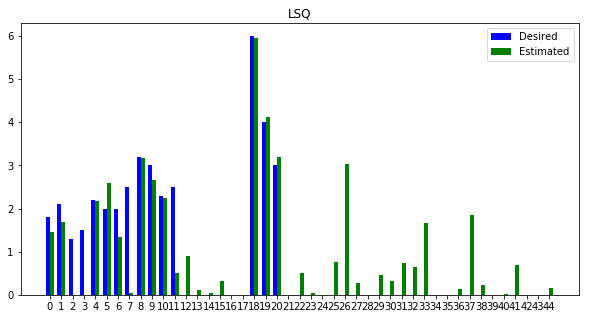

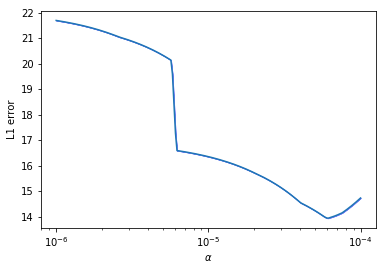

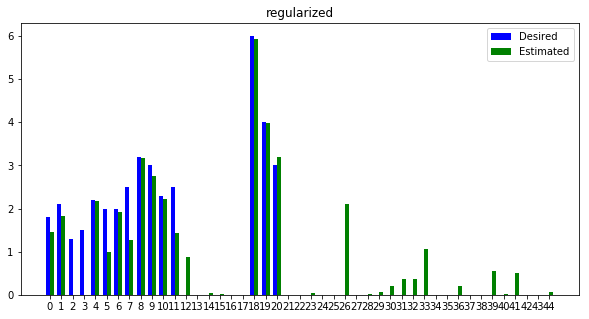

minimal l1 error: 13.943986870579032 (ix 178)


In [9]:
do(24e-3, 'case_1_dt_24e-3.pickle')